In [1]:
import torch
import numpy as np
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
import sys, os

from utils.plots import *
from utils.funcs import *
from utils.visualize_network import *
from utils.visualize_hidden_network import *

from boltzmann_machines.RTRBM_ import RTRBM
from boltzmann_machines.cp_rbm import RBM

from data.load_data import *
from data.mock_data import *
from data.reshape_data import *
from data.poisson_data_v import PoissonTimeShiftedData
from utils.moments_plot import infer_and_get_moments_plot


plt.rcParams["font.family"] = "Arial"

In this notebook we inspect the ability of the RTRBM to extract temporal dynamics of neural assemblies as a function of the interaction time. We hypothesise it is crucial to sample the data at the right frequency, such that most interactions happen at the same delay as the sampling. We test this by creating surrogate data that has temporal interactions with a delay of 4 time-steps. By down-sampling this data, training RTRBMs and quantifying their reconstruction performance we test this hypothesis.

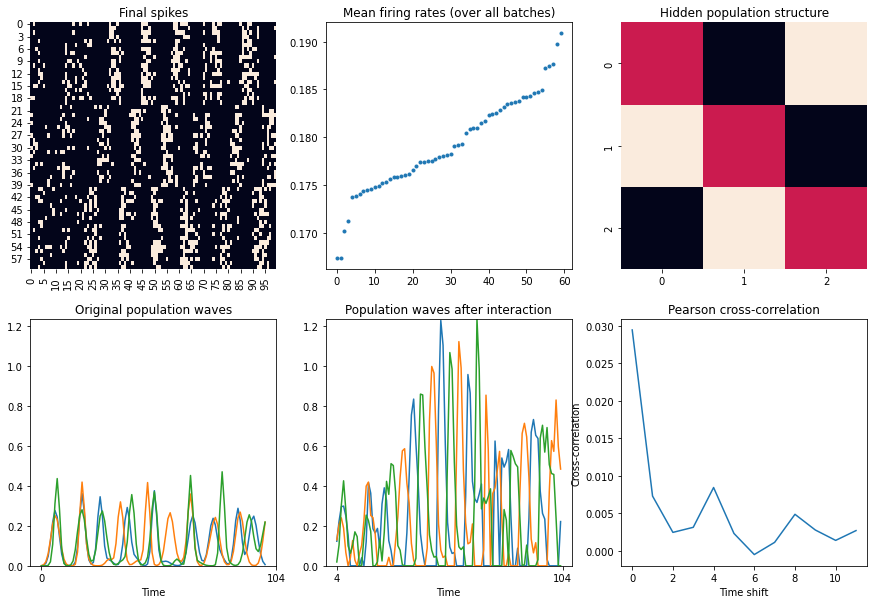

In [2]:
# population interaction delay
interaction_delay = 4

# number of populations and hidden units
n_h = 3

# create temporal connections
U_hat = create_U_hat(n_h) / 0.36

# create data
gaus = PoissonTimeShiftedData(
    neurons_per_population=20,
    n_populations=n_h,
    n_batches=35,
    norm=1,
    time_steps_per_batch=30000,
    fr_mode='gaussian',
    delay=interaction_delay,
    temporal_connections=U_hat,
)

# plot some statistics to get a sense of the data
axes = gaus.plot_stats(T=100)
plt.show()

In [3]:
path2dir = r'D:/OneDrive/RU/Intern/rtrbm_master/results/Downsampling/'
rtrbm_list = []

# perform 10 runs
for n in range(10):

    # create data
    gaus = PoissonTimeShiftedData(
        neurons_per_population=20,
        n_populations=n_h,
        n_batches=35,
        norm=1,
        time_steps_per_batch=30000,
        fr_mode='gaussian',
        delay=interaction_delay,
        temporal_connections=U_hat,
    )

    # down-sample data by 1, 2, ..., 10
    for down_sample in tqdm(np.arange(10) + 1):

        # perform down sampling, only take 35000 time-steps
        data = resample(reshape(gaus.data.detach().clone()), sr=down_sample, mode=2)[:, :35000]

        # reshape data to batches
        data = reshape(data, T=100, n_batches=350)

        # take 280 train batches and 70 test batches
        train, test = data[..., :280], data[..., 280:]

        # initialize and train RTRBM
        rtrbm = RTRBM(train, n_hidden=n_h, device='cuda')
        rtrbm.learn(n_epochs=200, batch_size=15, CDk=10, mom=0, wc=0, lr=1e-3, disable_tqdm=True)

        # save test set to class
        rtrbm.test = test

        # torch.save(rtrbm, path2dir + 'rtrbm_sr_%.1s_run_%.1s'%(downsample, n))
        rtrbm_list += [rtrbm]

# save list
torch.save(rtrbm_list, r'D:\OneDrive\RU\Intern\rtrbm_master\results\Downsampling\rtrbm_list.pt')

100%|██████████| 10/10 [35:43<00:00, 214.38s/it]


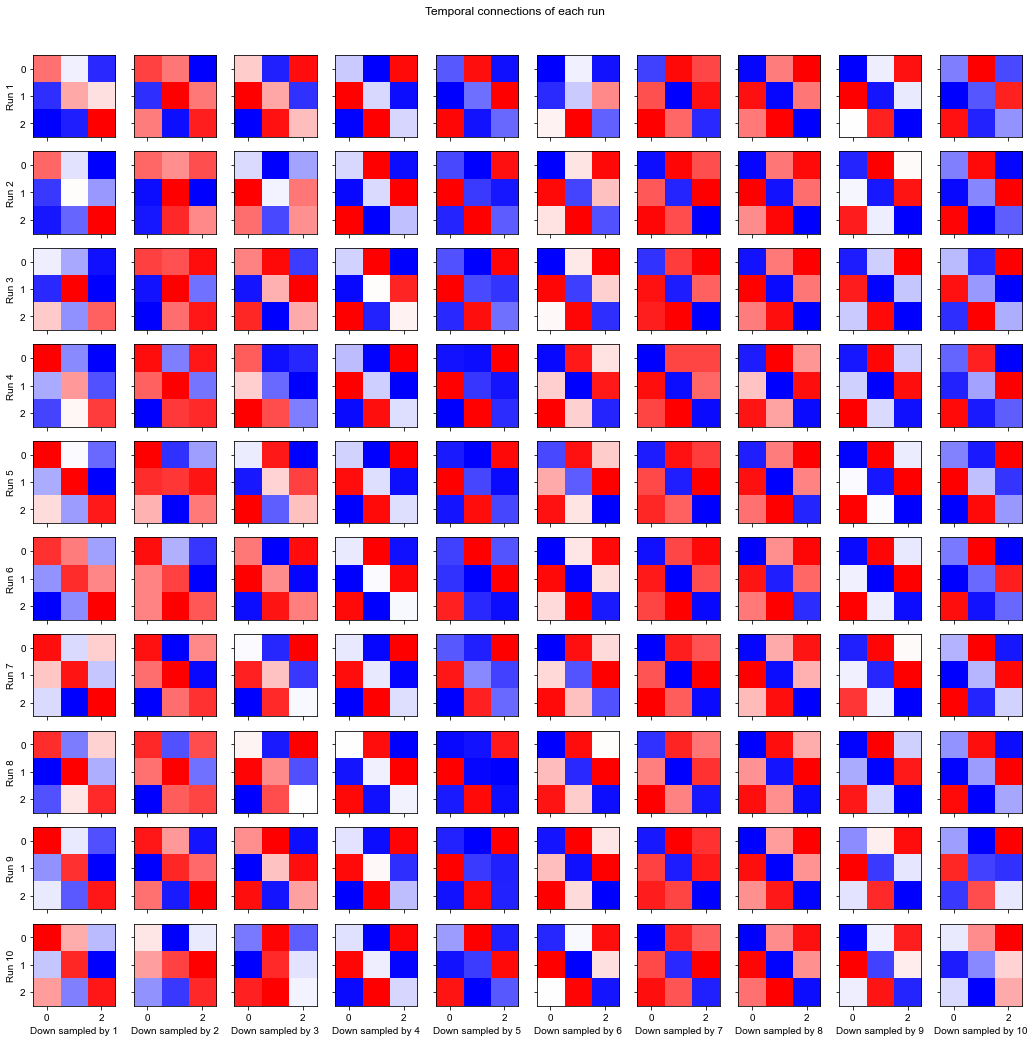

In [8]:
fig, axs = plt.subplots(10, 10, figsize=(15, 15), sharex=True, sharey=True)

for i, (rtrbm, ax) in enumerate(zip(rtrbm_list, axs.flatten())):
    ax.imshow(rtrbm.U.cpu(), cmap=plt.get_cmap('bwr'))

    row = i // 10
    col = i % 10
    if col == 0:
        ax.set_ylabel('Run %d' % (row + 1))
    if row == 9:
        ax.set_xlabel('Down sampled by %d' % (col + 1))

fig.suptitle('Temporal connections of each run')
plt.tight_layout(pad=3, h_pad=1.08, w_pad=1.08)

plt.show()

### Correlation between $U$ and $\hat{U}$

In [2]:
rtrbm_list = torch.load(r'D:\OneDrive\RU\Intern\rtrbm_master\results\Downsampling\rtrbm_list.pt')
U_hat = create_U_hat(3)

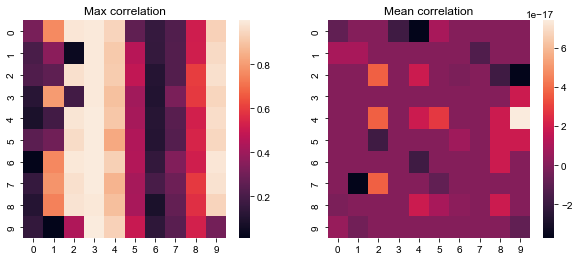

In [10]:
max_correlations = np.empty(len(rtrbm_list))
mean_correlations = np.empty(len(rtrbm_list))

# loop over rtrbm list
for i, rtrbm in enumerate(rtrbm_list):
    max_correlations[i] = get_best_correlation(rtrbm.U.cpu(), U_hat, mode='max')
    mean_correlations[i] = get_best_correlation(rtrbm.U.cpu(), U_hat, mode='mean')

# create subplots to plot U correlations
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

sns.heatmap(np.reshape(max_correlations, (10, 10)), ax=axs[0])
sns.heatmap(np.reshape(mean_correlations, (10, 10)), ax=axs[1])

axs[0].set_title('Max correlation')
axs[1].set_title('Mean correlation')

plt.show()

Best measure is definitely max correlation

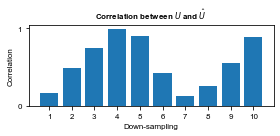

In [17]:
fig, ax = plt.subplots(figsize=(4, 2))

ax.bar(np.arange(10) + 1, np.mean(np.reshape(max_correlations, (10, 10)), 0))
ax.set_title('Correlation between $U$ and $\hat{U}$', fontsize=8, fontweight='bold')
ax.set_xlabel('Down-sampling', fontsize=8)
ax.set_ylabel('Correlation', fontsize=8)
ax.set_yticks([0, 1])
ax.set_yticklabels([0, 1], fontsize=8)
ax.set_xticks(np.arange(10) + 1)
ax.set_xticklabels(np.arange(10) + 1, fontsize=8)

plt.tight_layout()
plt.savefig(r'D:\OneDrive\RU\Intern\rtrbm_master\figures\Paper Figures\Supplementary Figures\downsampling.png', dpi=1000)

plt.show()

Leave out 9 and 10 to avoid confusion

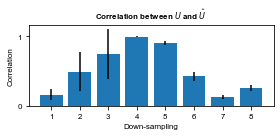

In [22]:
data = np.reshape(max_correlations, (10, 10))[:, :8]

fig, ax = plt.subplots(figsize=(4, 2))

ax.bar(np.arange(8) + 1, np.mean(data, 0), yerr=np.std(data, 0))
ax.set_title('Correlation between $U$ and $\hat{U}$', fontsize=8, fontweight='bold')
ax.set_xlabel('Down-sampling', fontsize=8)
ax.set_ylabel('Correlation', fontsize=8)
ax.set_yticks([0, 1])
ax.set_yticklabels([0, 1], fontsize=8)
ax.set_xticks(np.arange(8) + 1)
ax.set_xticklabels(np.arange(8) + 1, fontsize=8)

plt.tight_layout()
plt.savefig(r'D:\OneDrive\RU\Intern\rtrbm_master\figures\Paper Figures\Supplementary Figures\downsampling.png', dpi=1000)

plt.show()